In [1]:
import pandas as pd
import os
import pathlib
import shutil
from moleculekit.molecule import Molecule
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [2]:
cd /data_st02/drug/inoue/CGBVS

/data_st02/drug/inoue/CGBVS


## config

In [3]:
th = 30 # μM
datatype = "refined" # [refined or general]

# データの読み込み

データの読み込み

In [4]:
def load_pl_name(path):
    ## read file
    f = open(path, 'r', encoding='UTF-8')
    list = [s for s in f.readlines() if not s.startswith('#')]
    pdb_id = [l[:4] for l in list]
    #release_year = [l[4:10].strip() for l in list]
    uniprot_id = [l[12:20].strip() for l in list]
    protein_name = [l[21:].strip() for l in list]
    f.close()
    pl_name = pd.DataFrame([pdb_id, uniprot_id, protein_name],
                            index=['pdb_id', 'Uniprot ID', 'protein name']).T
    return pl_name

def load_pl_data(path):
    ## read file ===========-
    f = open(path, 'r', encoding='UTF-8')
    list = [s for s in f.readlines() if not s.startswith('#')]
    pdb_id = [l[:4] for l in list]
    resolution = [l[4:10].strip() for l in list]
    release_year = [l[11:16].strip() for l in list]
    log_kdki = [l[17:23].strip() for l in list]
    kdki = [l[24:39].strip() for l in list]
    reference = [l[42:50].strip() for l in list]
    ligand_name = [l[51:].strip("( ) \n") for l in list]
    f.close()

    ## data reshape =========
    ## col kd,ki,IC50
    label, rel, af, c = [],[],[],[]
    for d in kdki:
        if '<=' in d:
            label.append(d.split('<=')[0]) # Ki
            rel.append('<=')  # =, <
            af.append(d.split('<=')[1][:-2]) # 100
            c.append(d.split('<=')[1][-2:]) # nM
        elif '>=' in d:
            label.append(d.split('>=')[0])  # Ki
            rel.append('>=')  # =, <
            af.append(d.split('>=')[1][:-2])  # 100
            c.append(d.split('>=')[1][-2:])  # nM
        elif '~' in d:
            label.append(d.split('~')[0])  # Ki
            rel.append('~')  # =, <
            af.append(d.split('~')[1][:-2])  # 100
            c.append(d.split('~')[1][-2:])  # nM
        elif '>' in d:
            label.append(d.split('>')[0])  # Ki
            rel.append('>')  # =, <
            af.append(d.split('>')[1][:-2])  # 100
            c.append(d.split('>')[1][-2:])  # nM
        elif '<' in d:
            label.append(d.split('<')[0])  # Ki
            rel.append('<')  # =, <
            af.append(d.split('<')[1][:-2])  # 100
            c.append(d.split('<')[1][-2:])  # nM
        elif '=' in d:
            label.append(d.split('=')[0])  # Ki
            rel.append('=')  # =, <
            af.append(d.split('=')[1][:-2])  # 100
            c.append(d.split('=')[1][-2:])  # nM
        else:
            print("[ERROR]")

    ## set dataframe
    pl_data = pd.DataFrame([pdb_id,resolution,release_year,log_kdki,label,rel,af,c,reference,ligand_name],
                      index=['pdb_id', 'resolution', 'release_year', 'log_kdki', 'af_kikd', 'af_rel','af_val','af_unit','reference','ligand_name']).T

    ## unit
    vals = [] # μMに揃える
    for i,unit in enumerate(pl_data['af_unit'].tolist()):
        if unit == 'mM':
            val_ = float(pl_data['af_val'][i])*1000
        elif unit == 'uM':
            val_ = float(pl_data['af_val'][i])*1
        elif unit == 'nM':
            val_ = float(pl_data['af_val'][i])/1000
        elif unit == 'pM':
            val_ = float(pl_data['af_val'][i])/1000000
        elif unit == 'fM':
            val_ = float(pl_data['af_val'][i])/1000000000
        else:
            print('[ERROR]')
            pass
        vals.append(val_)
    pl_data['af_val'] = vals
    pl_data['af_unit'] = 'μM'
    return pl_data

In [7]:
#df_name = load_pl_name(f'data/original/PDBbind/index/INDEX_{datatype}_PL_name.2020')
#df_data_r = load_pl_data(f'data/original/PDBbind/index/INDEX_{datatype}_PL_data.2020')
df_name = load_pl_name(f'data/original/PDBbind/index/INDEX_{datatype}_name.2020')
df_data_r = load_pl_data(f'data/original/PDBbind/index/INDEX_{datatype}_data.2020')

In [3]:
#%%
def load_pl_name(path):
    ## PL_name
    f = open(path, 'r', encoding='UTF-8')
    list = [s.strip('\n').split('  ', 3)
            for s in f.readlines() if not s.startswith('#')]
    #print(list)
    f.close()
    pl_name = pd.DataFrame(
        list, columns=['PDB code', 'release year', 'Uniprot ID', 'protein name'])
    return pl_name


def load_pl_data(path):
    ## PL_data
    f = open(path, 'r', encoding='UTF-8')
    list = [s.strip('\n').split('  ', 5)
            for s in f.readlines() if not s.startswith('#')]
    #print(list)
    f.close()

    pl_data = pd.DataFrame(
        list, columns=['PDB code', 'resolution', 'release year', '-logKd/Ki', 4, 5])

    ## Kd/Ki
    affinity_label, rel, c = [], [], []
    for i in range(len(pl_data[4])):
        if '=' in pl_data[4][i]:
            affinity_label_ = pl_data[4][i].split('=')[0]
            rel_ = '='
            c_ = pl_data[4][i].split('=')[1]
        elif '>' in pl_data[4][i]:
            affinity_label_ = pl_data[4][i].split('>')[0]
            rel_ = '>'
            c_ = pl_data[4][i].split('>')[1]
        elif '~' in pl_data[4][i]:
            affinity_label_ = pl_data[4][i].split('~')[0]
            rel_ = '~'
            c_ = pl_data[4][i].split('~')[1]
        affinity_label.append(affinity_label_)  # Ki, Kd, IC50
        rel.append(rel_)  # = > ~
        c.append(c_)  # score

    affinity_score = []  # 単位 = u
    for i in range(len(c)):
        if c[i][-2] == 'm':
            score_ = float(c[i][:-2])*1000
        elif c[i][-2] == 'u':
            score_ = float(c[i][:-2])*1
        elif c[i][-2] == 'n':
            score_ = float(c[i][:-2])/1000
        elif c[i][-2] == 'p':
            score_ = float(c[i][:-2])/1000000
        elif c[i][-2] == 'f':
            score_ = float(c[i][:-2])/1000000000
        affinity_score.append(score_)

    pl_data['af_label'] = affinity_label
    pl_data['af_relation'] = rel
    pl_data['af_score'] = affinity_score

    ## reference, ligand_name
    reference, ligand_name = [], []
    for i in range(len(pl_data[5])):
        if pl_data[5][i] is not None:
            x_ = pl_data[5][i].split('// ')[1]
            reference_ = x_.split('(')[0].split(' ')[0]  # 3zzf.pdf
            ligand_name_ = x_.split('(')[1].split(')')[0]  # NLG
            reference.append(reference_)
            ligand_name.append(ligand_name_)
        else:
            reference.append('')
            ligand_name.append('')

    pl_data['reference'] = reference
    pl_data['ligand name'] = ligand_name
    #pl_name = pd.DataFrame(list, columns=['PDB code', 'release year', 'Uniprot ID', 'protein name'])
    #pl_data['reference'] = [s for s in pl_data[5]]
    #pl_data['affinity_score'] = [s.split('=')[1] for s in pl_data[4]]

    data = pl_data.drop([4, 5], axis=1)
    return data


In [4]:
## human, kinaseに限定
path = "/data_st02/drug/inoue/CGBVS/data/other/uniprot/uniprot_kinase_human.list"
f = open(path, 'r', encoding='UTF-8')
human_id = [s.strip('\n') for s in f.readlines()]
#print(list)
f.close()
len(human_id)


3262

In [5]:
## load_data
general_name_ = load_pl_name('data/other/PDBbind/index/INDEX_general_PL_name.2020')
general_data = load_pl_data('data/other/PDBbind/index/INDEX_general_PL_data.2020')
refined_name_ = load_pl_name('data/other/PDBbind/index/INDEX_refined_name.2020')
refined_data = load_pl_data('data/other/PDBbind/index/INDEX_refined_data.2020')
general_name = general_name_[general_name_['Uniprot ID'].isin(human_id)].drop('release year', axis=1)
refined_name = refined_name_[refined_name_['Uniprot ID'].isin(human_id)].drop('release year', axis=1)


In [6]:
refined = refined_name.merge(refined_data, how='left', left_on='PDB code', right_on='PDB code')
general = general_name.merge(general_data, how='left', left_on='PDB code', right_on='PDB code')


In [7]:
print(f'unique PDB_id (general) = {len(general["PDB code"].unique())}')
print(f'unique PDB_id (refine) = {len(refined["PDB code"].unique())}')
print(f'unique protein (general) = {len(general["protein name"].unique())}')
print(f'unique protein (refine) = {len(refined["protein name"].unique())}')


unique PDB_id (general) = 2836
unique PDB_id (refine) = 395
unique protein (general) = 292
unique protein (refine) = 93


In [8]:
general

,PDB code,Uniprot ID,protein name,resolution,release year,-logKd/Ki,af_label,af_relation,af_score,reference,ligand name
0,5swg,P42336,"PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE",3.11,2017,4.48,IC50,=,33.00000,5sw8.pdf,CAQ
1,5sxk,P42336,"PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE",3.55,2017,4.70,IC50,=,20.00000,5sw8.pdf,71K
2,4waf,P42336,"PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE",2.39,2014,5.00,IC50>,=,10.00000,4waf.pdf,3K6
3,5xgh,P42336,"PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE...",2.97,2018,5.99,IC50,=,1.02000,5xgh.pdf,84U
4,6gvg,P42336,"PHOSPHATIDYLINOSITOL 4,5-BISPHOSPHATE 3-KINASE...",3.00,2019,6.00,Ki,=,0.99000,6gvf.pdf,FCZ
...,...,...,...,...,...,...,...,...,...,...,...
2831,1lcj,P06239,P56==LCK== TYROSINE KINASE,1.80,1995,9.00,Kd,=,0.00100,1lcj.pdf,11-mer
2832,5j18,P15056,SERINE/THREONINE-PROTEIN KINASE B-RAF,NMR,2016,9.15,Kd,=,0.00071,5j18.pdf,6FS
2833,2oi3,P08631,TYROSINE-PROTEIN KINASE HCK,NMR,2007,6.64,Kd,=,0.23000,2oi3.pdf,14-mer
2834,4znx,P06241,TYROSINE-PROTEIN KINASE FYN,2.10,2016,6.62,Kd,=,0.24000,4znx.pdf,12-mer


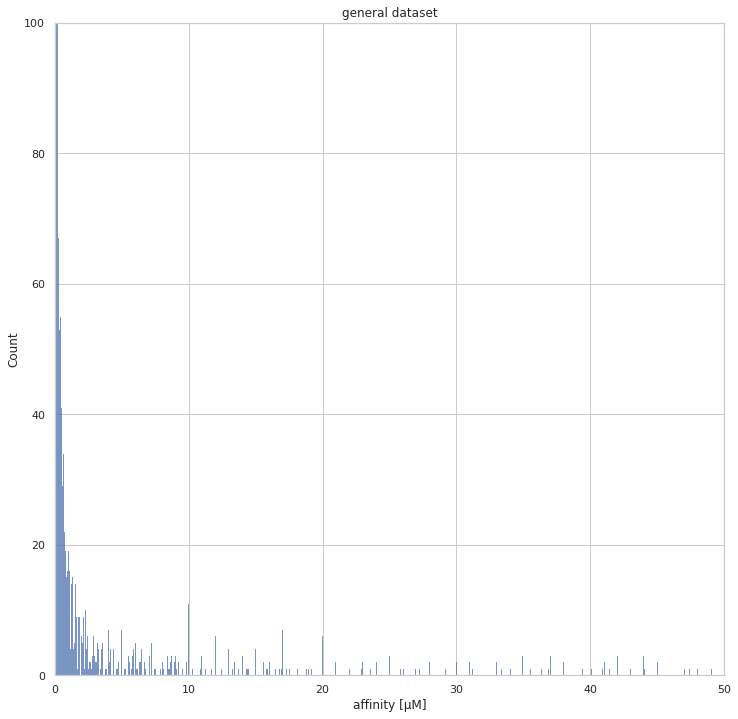

In [13]:
sns.set()
sns.set_style('whitegrid')
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot()
sns.histplot(ax=ax, data=general["af_score"])
ax.set_xlim(0, 50)
ax.set_ylim(0, 100)
ax.set_xlabel('affinity [μM]')
ax.title.set_text(f"general dataset")


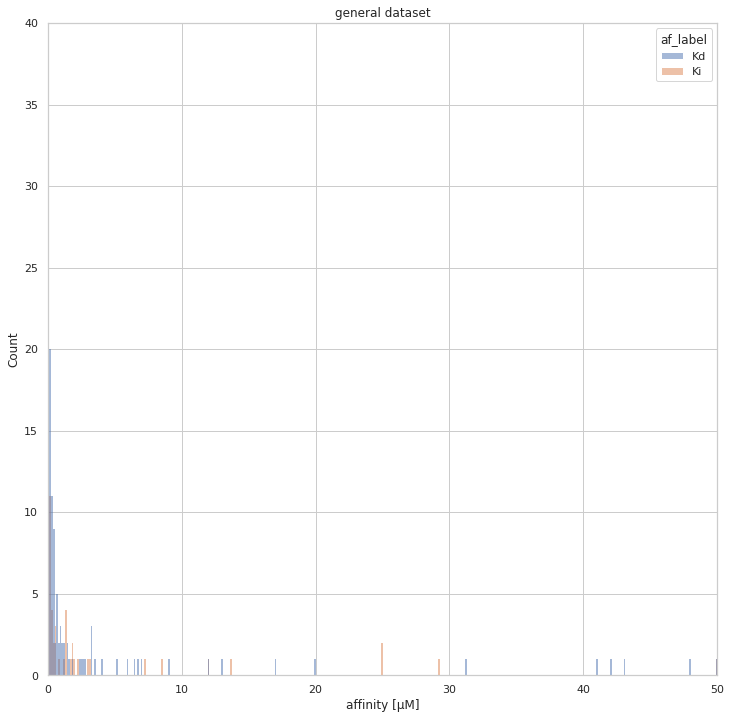

In [12]:
sns.set()
sns.set_style('whitegrid')
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot()
sns.histplot(ax=ax, data=refined, x="af_score", hue="af_label")
ax.set_xlim(0, 50)
ax.set_ylim(0, 40)
ax.set_xlabel('affinity [μM]')
ax.title.set_text(f"general dataset")


In [9]:
print(f"over 30u data count (refined) = {len(refined[refined['af_score'] > 30])}")
print(f"under 30u data count (refined)= {len(refined[refined['af_score'] <= 30])}")
print(f"over 30u data count (general)= {len(general[general['af_score'] > 30])}")
print(f"under 30u data count (general)= {len(general[general['af_score'] <= 30])}")

over 30u data count (refined) = 33
under 30u data count (refined)= 362
over 30u data count (general)= 182
under 30u data count (general)= 2654
